## Setup

In [1]:
import importlib
import helper, consts
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import json

In [2]:
TEST_DATE = "20211201"
FILE_PATH = "../Data/"

In [3]:
# helper.downloaded_all_data(output_dir=FILE_PATH, file_count=50)

## Data Analysis

In [4]:
importlib.reload(helper); importlib.reload(consts)

<module 'consts' from '/Users/hoangchu/Documents/Clinic/code/consts.py'>

We're predicting 1-day ahead

In [5]:
data = helper.Data(train_data_path=FILE_PATH)
train_df = data.update_and_get_train_df(TEST_DATE, backward_dayCount = 1)

Getting files from 2021-11-29 00:00:00 to 2021-11-30 00:00:00, inclusive.


#### Remove highly correlated features

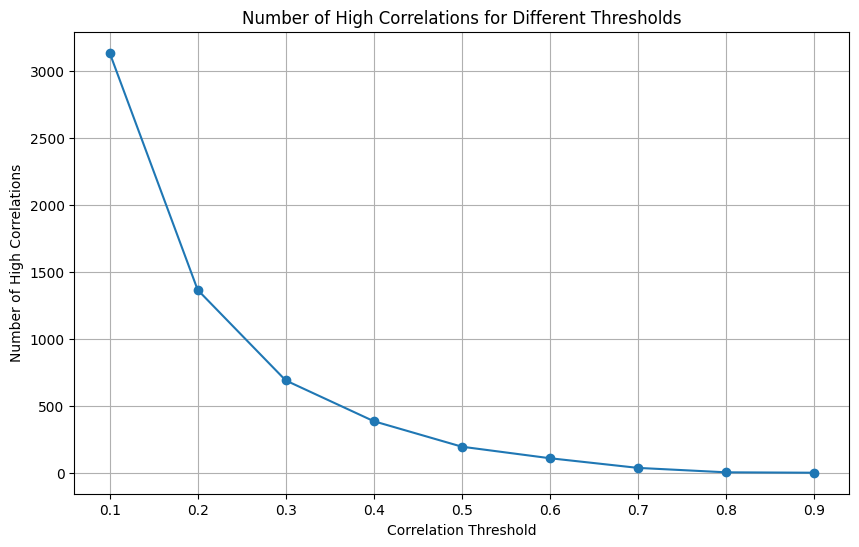

At corr = .7: There are 37 features
At corr = .8: There are 4 features


In [6]:
data.plot_high_corr("high_corr")
print(f"At corr = .7: There are {len(data.find_high_corr(.7))} features")
print(f"At corr = .8: There are {len(data.find_high_corr(.8))} features")

Because there are significantly more features (37 vs 4) having .7 correlation threshold than .8, remove at threshold .8 or above

In [7]:
removable_features = []

highCorr_features_map = data.find_high_corr(.8)

for _, highCorr_pairs in highCorr_features_map.items():
    for (feature1, feature2) in highCorr_pairs:
        insig_features = helper.hypothesis_test_features(data.train_df, feature1, feature2, alpha = .01)
        removable_features.extend(insig_features)

len(removable_features) # confirm the same number as determined above.

4

The previous cell was a demonstration and I have incorporated it to Data class internally.

In [8]:
data.train_df.drop(removable_features, axis = consts.COL, inplace=True)

### Initial view of the response value.

Thanks to our robust back-end infra, we can have an universal TEST_DF and just need to update train_df for our needs.

In [9]:
data.update_and_get_test_df(data_path=FILE_PATH, start_date=TEST_DATE)
TEST_DF = data.test_dfs[0]

Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.


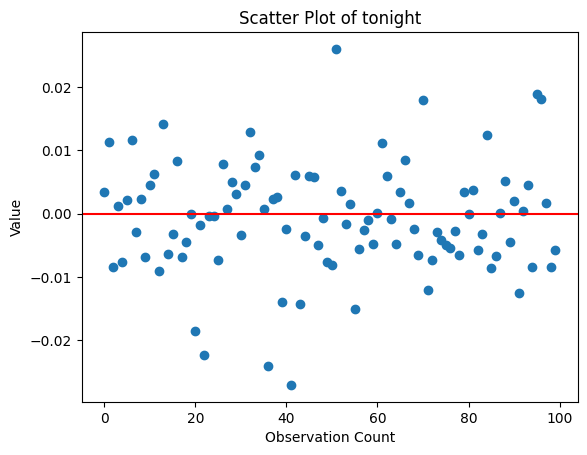

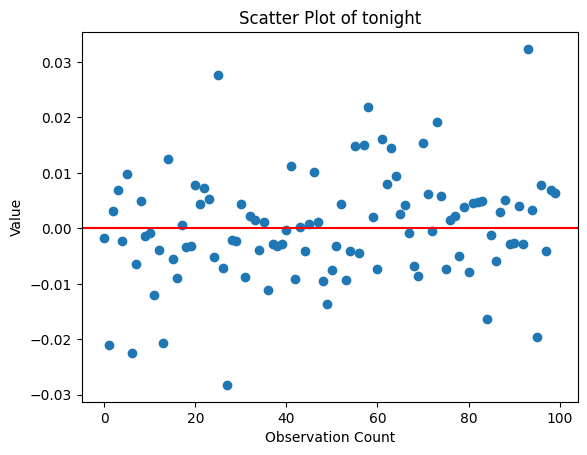

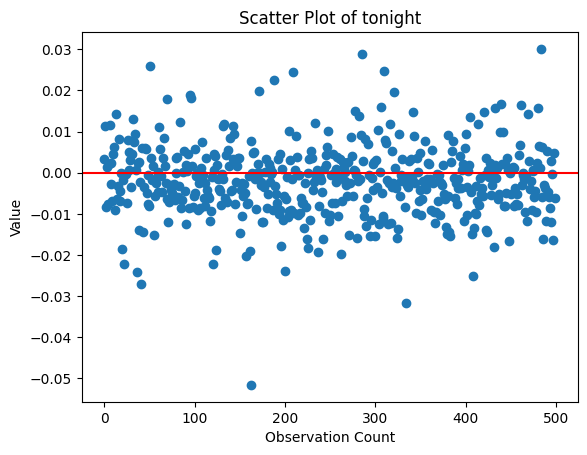

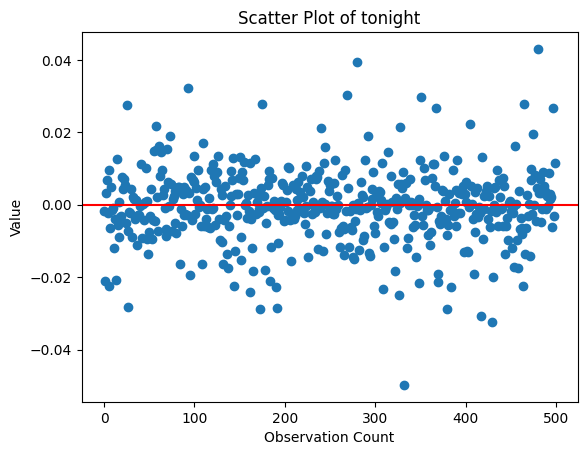

In [10]:
helper.scatter_lot(train_df, consts.RESPONSE_NAME, 100)
helper.scatter_lot(TEST_DF, consts.RESPONSE_NAME, 100)
helper.scatter_lot(train_df, consts.RESPONSE_NAME, 500)
helper.scatter_lot(TEST_DF, consts.RESPONSE_NAME, 500)

A balanced response values scattering no need for add / remove more data

## Linear Feature Selection

### Base Linear Model

This will be used as a comparative base model.

In [11]:
importlib.reload(helper); importlib.reload(consts)

<module 'consts' from '/Users/hoangchu/Documents/Clinic/code/consts.py'>

The experiment below will be a sample of every experiment -- concise and powerful thanks to our back-end infra.

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 246
response_corr: 0.8597933792285342
scale_factor: 0.95134131494762
mean_return: 0.009079263881253435
Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.


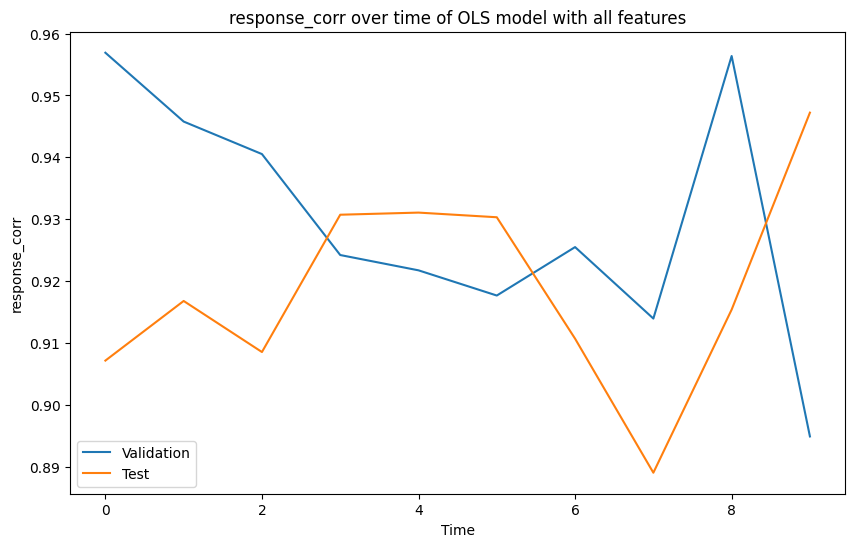

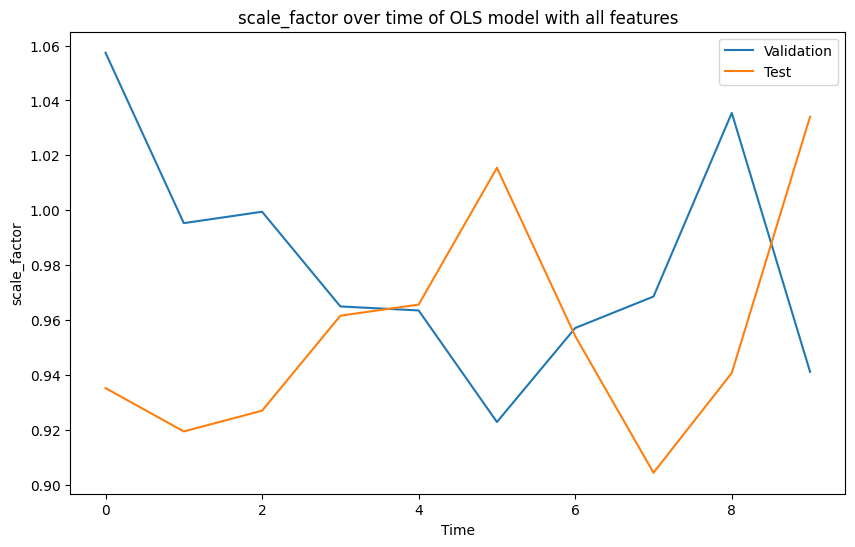

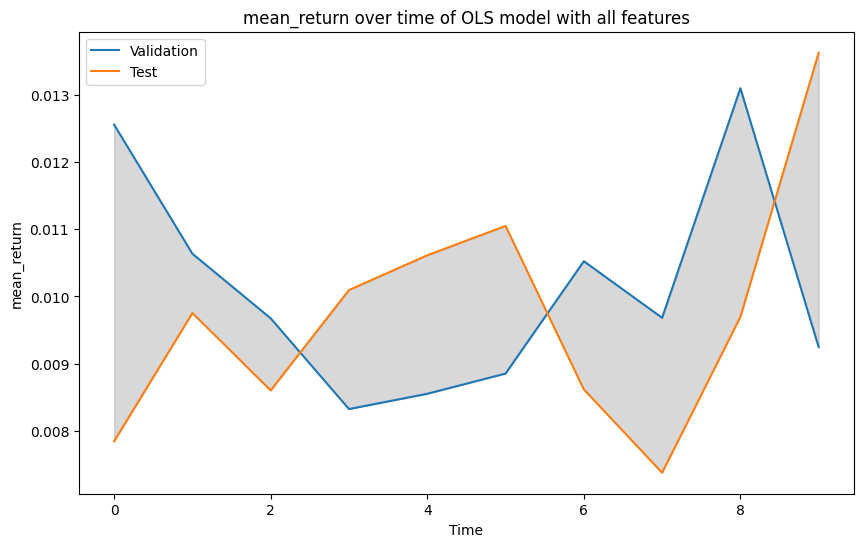

In [12]:
model1 = helper.Model('OLS')
model1.train(train_df)
model1.test(TEST_DF)
helper.validation_plot(data, model1, 10, "20211201", train_data_count=30, data_path=FILE_PATH, forward_dayCount = 15)

It's evident from the mean return plot that the in-sample return outperforms the out-of-sample return most of the time, meaning the linear model given all the features does not generalize well and should not be used.

### Stepwise

Since Linear Model is a deterministic algorithm, most of the time it's overfitting due to having too many semi-correlated features that does not correlated or little correlated to the response value, hence affect the projected prediction vector. Stepwise is an approach to greedily pick only the features correlated to the response value -- i.e picking the subset that combined giving ust the best r^2.

In [13]:
importlib.reload(helper); importlib.reload(consts)

<module 'consts' from '/Users/hoangchu/Documents/Clinic/code/consts.py'>

This example shows how to perform a feature selection technique. Once again, 3 lines, concise and elegent, thanks to the back-end infra.

In [14]:
stepwise_features = helper.stepwise_selection(X = train_df.drop(consts.RESPONSE_NAME, axis = consts.COL), y = train_df[consts.RESPONSE_NAME])
export_path = "Hoang_stepwise_features.txt"
helper.extract_features_to_file(stepwise_features, export_path)

Add dn1                            with p-value 0.0
Add tmwam                          with p-value 0.0
Add today                          with p-value 0.0
Add cftorrrelstd_open_0            with p-value 1.78953e-40
Add llirpnxm_toxhr_0               with p-value 8.10786e-27
Add totrisklog_open_0              with p-value 8.12846e-19
Add llirpnxm_lst15_0               with p-value 1.61661e-14
Add llirpnxm_dy_7to11              with p-value 1.84316e-13
Add dn4x1                          with p-value 5.43184e-14
Add llirpnxm_pm_1                  with p-value 8.35769e-11
Add llirpnxm_dy_4to6               with p-value 6.70651e-12
Add relvol_nt_17to21               with p-value 1.10513e-06
Add rrretstr_nt_0                  with p-value 3.28087e-07
Add tr_nt_1                        with p-value 8.39732e-07
Add relvol_lst15_0                 with p-value 2.76178e-06
Add rrirpnxm_lsthrx15_0            with p-value 2.95262e-05
Add relntrds70tr_am_1              with p-value 5.04143e-05
Add 

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 41
response_corr: 0.8654946737710241
scale_factor: 0.9601329815962518
mean_return: 0.009138500274876305
Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.


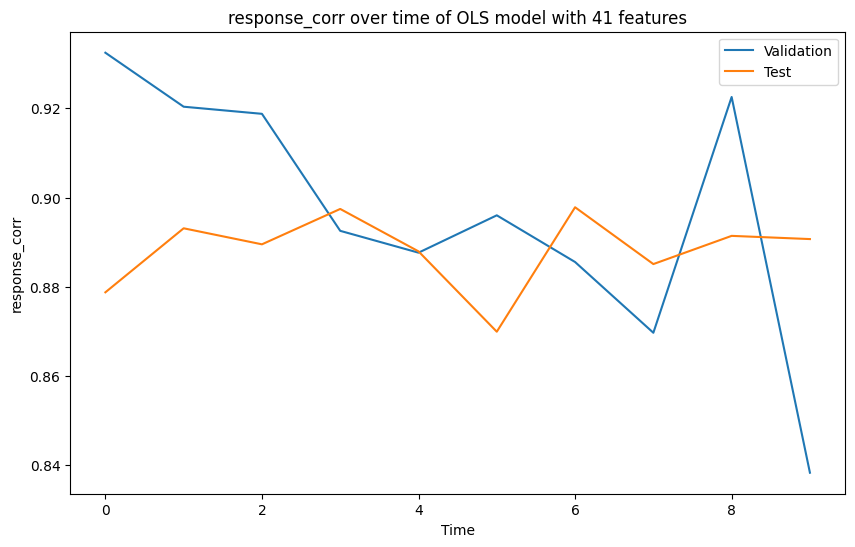

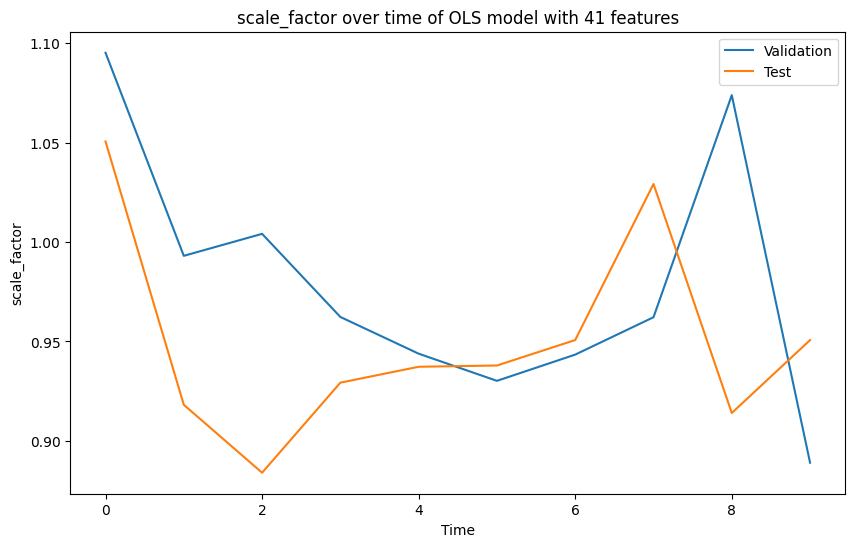

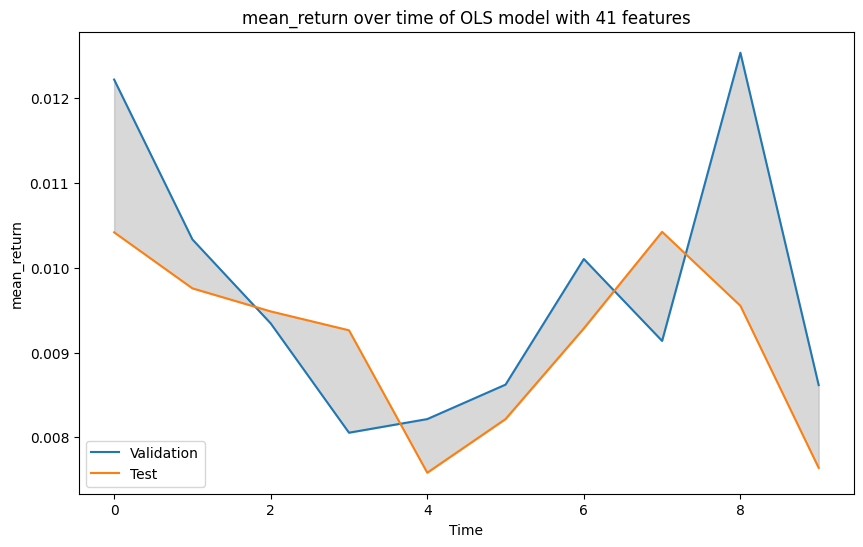

In [15]:
model2 = helper.Model('OLS')
model2.train(train_df, feature_col_names = stepwise_features)
model2.test(TEST_DF)
helper.validation_plot(data, model2, 10, "20211201", train_data_count=30, data_path=FILE_PATH, forward_dayCount = 15, features = stepwise_features)

### Stepwise - LASSO

In [16]:
importlib.reload(helper); importlib.reload(consts)

<module 'consts' from '/Users/hoangchu/Documents/Clinic/code/consts.py'>

In [17]:
stepwise_lasso_features = helper.LASSO_feature_selection(train_df, TEST_DF, features=stepwise_features)

You're using: LASSO.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}
No. features being used: 41
response_corr: 0.8759030374009844
scale_factor: 1.0066714872111082
mean_return: 0.009297354040681693


You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 32
response_corr: 0.873469164160942
scale_factor: 0.9563789784579798
mean_return: 0.009306934029686641
Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.


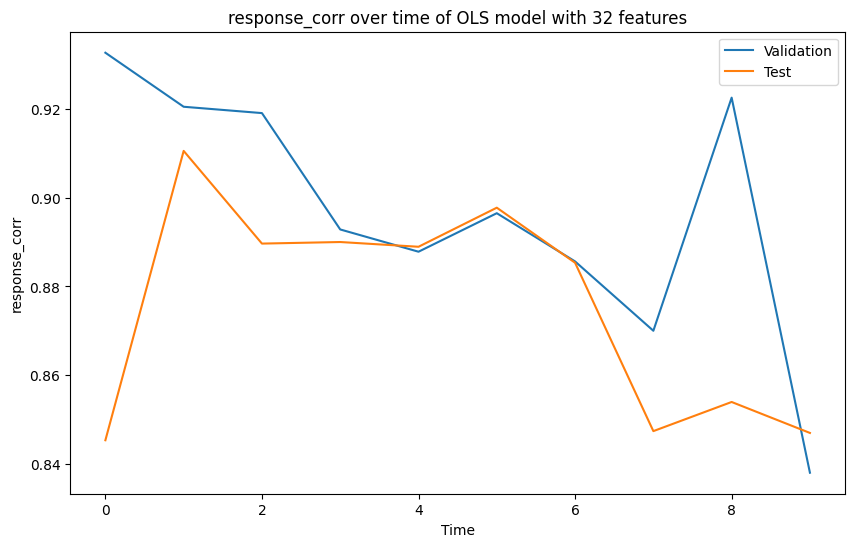

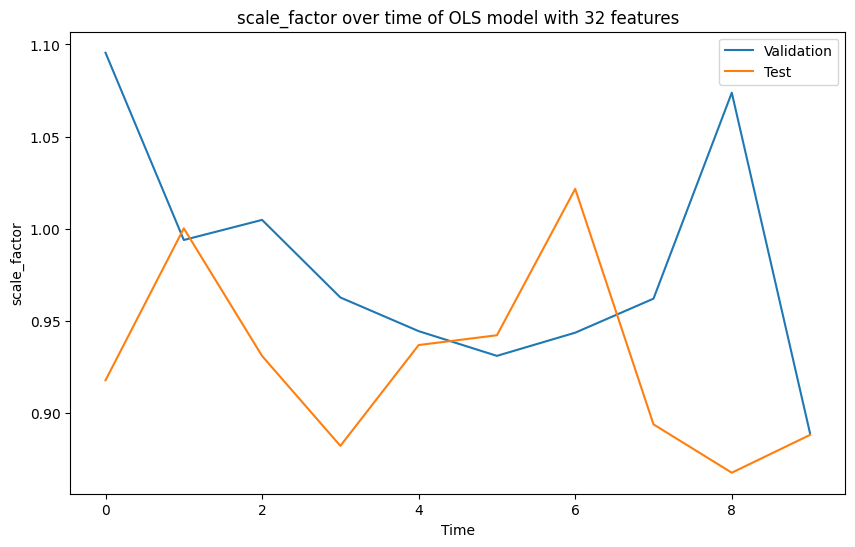

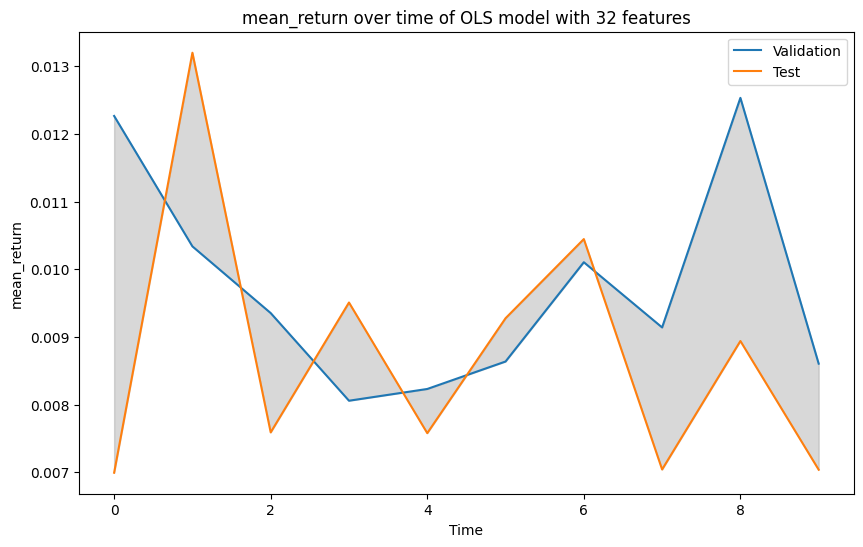

In [18]:
model3 = helper.Model('OLS')
model3.train(train_df, feature_col_names = stepwise_lasso_features)
model3.test(TEST_DF)
helper.validation_plot(data, model3, 10, "20211201", train_data_count=30, data_path=FILE_PATH, forward_dayCount = 15, features = stepwise_lasso_features)

The mean return plot showing it's still an even play between in-sample and out-of-sample returns. This means using LASSO after Stepwise isn't better than just using Stepwise.

### LASSO

Instead of being super strict on features being most correlated with the response variable AND not too much correlated with other features, what if we lax the first requirement?

Again, we don't even need to reload the notebook from the beginning and continue the experiment with a fresh dataset thanks to our very robust backend.

In [19]:
importlib.reload(helper); importlib.reload(consts)

<module 'consts' from '/Users/hoangchu/Documents/Clinic/code/consts.py'>

In [20]:
lasso_features = helper.LASSO_feature_selection(train_df, TEST_DF)
export_path = "Hoang_lasso_features.txt"
helper.extract_features_to_file(lasso_features, export_path)

You're using: LASSO.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}
No. features being used: 246
response_corr: 0.8712357178454512
scale_factor: 0.9939670293770039
mean_return: 0.009271060472787246


You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 169
response_corr: 0.8689127791358449
scale_factor: 0.9453374683194519
mean_return: 0.009226229246838922
Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.


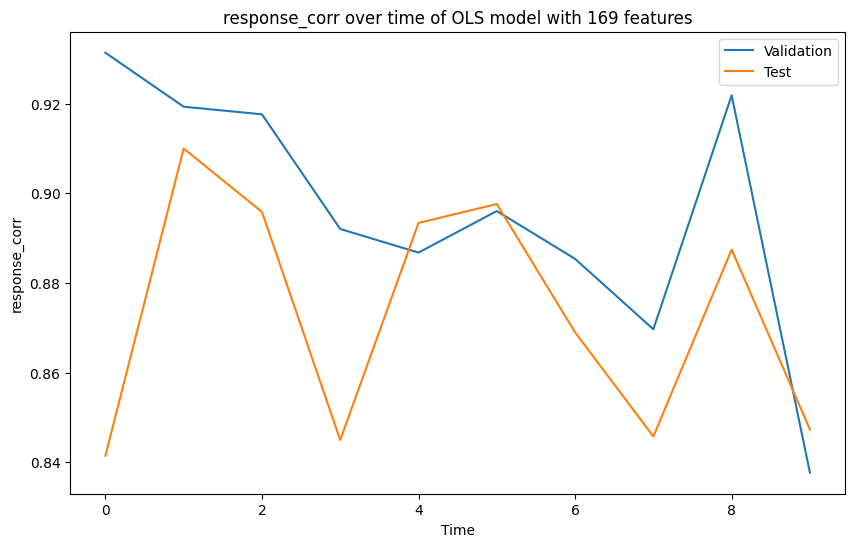

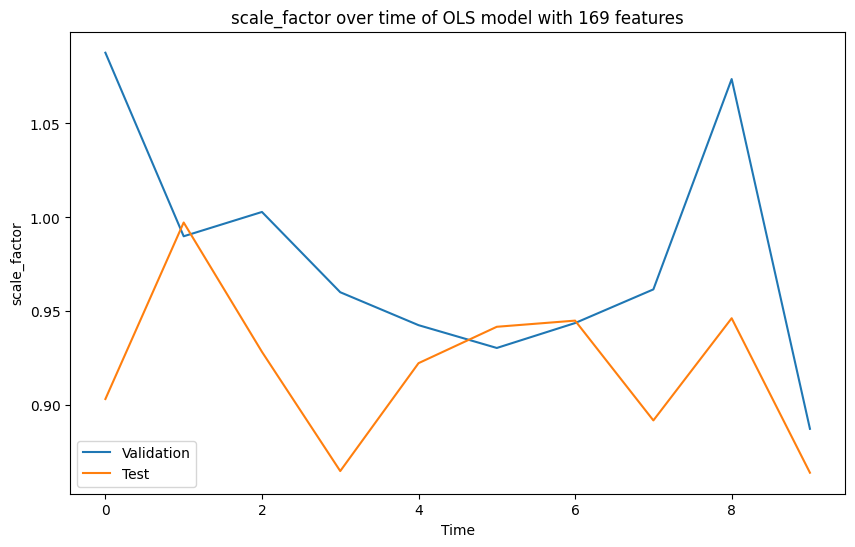

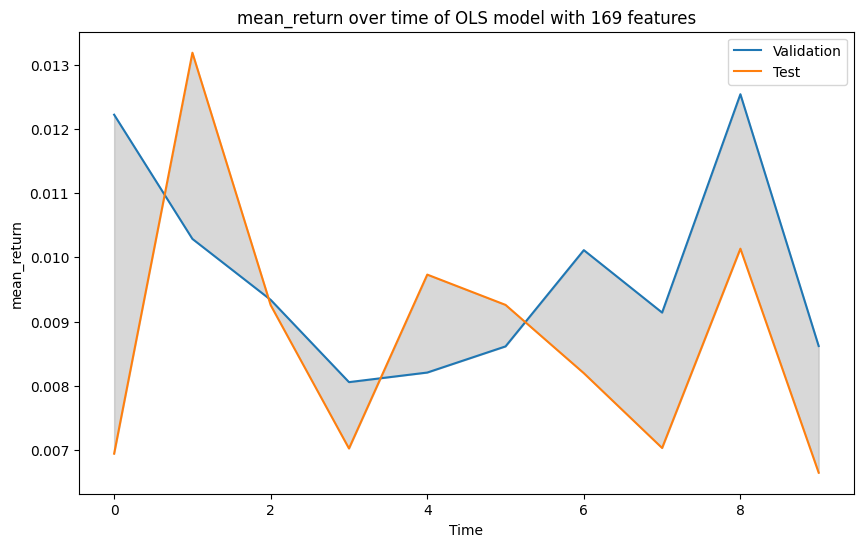

In [21]:
model4 = helper.Model('OLS')
model4.train(train_df, feature_col_names = lasso_features)
model4.test(TEST_DF)
helper.validation_plot(data, model4, 10, "20211201", train_data_count=30, data_path=FILE_PATH, forward_dayCount = 15, features = lasso_features)

From the plot, we can see it performs worse than Stepwise then LASSO or Stepwise itself. This means our upper bound for number of features is 41.

### Genetic Algorithm

Genetic algorithms select the best candidates at each generation and “evolve” them to create a new generation, improving the overall quality of the candidate pool over time. In this particular problem, we believe that the best possible “signal” would be a combination of multiple features, so we would prefer that the algorithm doesn’t converge on a best single feature. (As show in LASSO and Stepwise)

To address this, we attempted to lend a bit the power of both LASSO (generalizes out-of-sample well in predicting price movement) and Stepwise (generalizes out-of-sample well in predicting the exact price) mechanism.

This means we add a decorrelate function to the features selected at each generation. This means in the “fitness function”, in addition to the feature having the best prediction outcome, we also prefers features that maximize the feature's correlation with the target returns while minimizing correlation with other features.

#### Stepwise - Genetic Algo

In [22]:
importlib.reload(helper); importlib.reload(consts)

<module 'consts' from '/Users/hoangchu/Documents/Clinic/code/consts.py'>

In [23]:
df = train_df.drop(consts.RESPONSE_NAME, axis = consts.COL, inplace = False)
ga_feature_indices = helper.genetic_algorithm(train_df, TEST_DF, stepwise_features)
ga_features = [df.columns[i] for i in range(len(ga_feature_indices)) if ga_feature_indices[i] == 1]
export_path = "Hoang_stepwise_genetic_algo_features.txt"
helper.extract_features_to_file(ga_features, export_path)

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 17
response_corr: 0.8820767151827378
scale_factor: 0.9919467174034852
mean_return: 0.009366783397471138
Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.


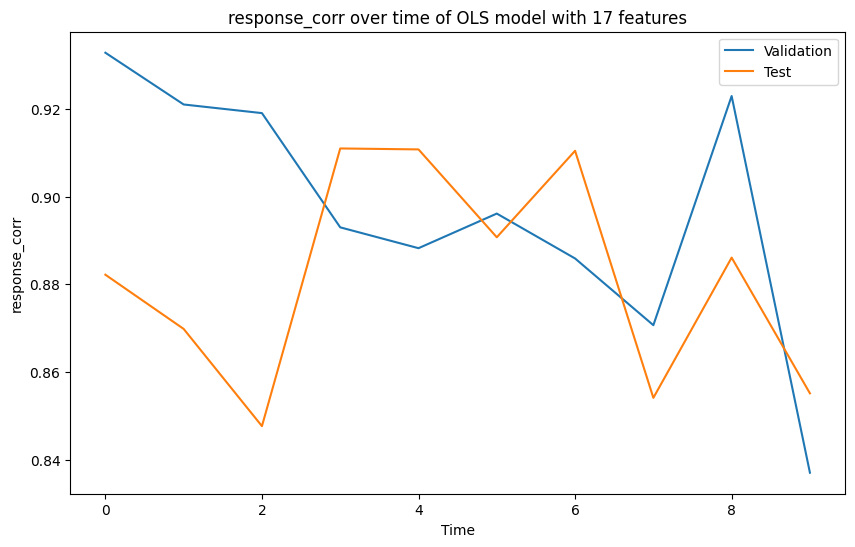

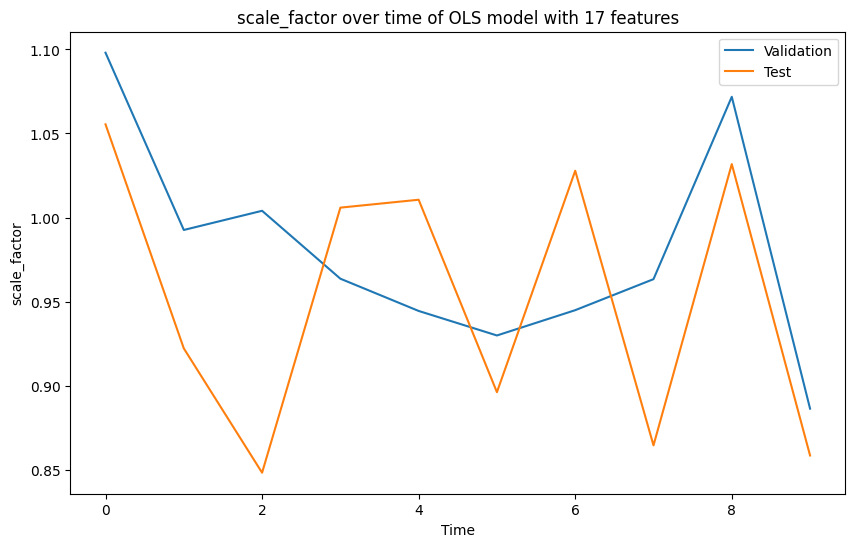

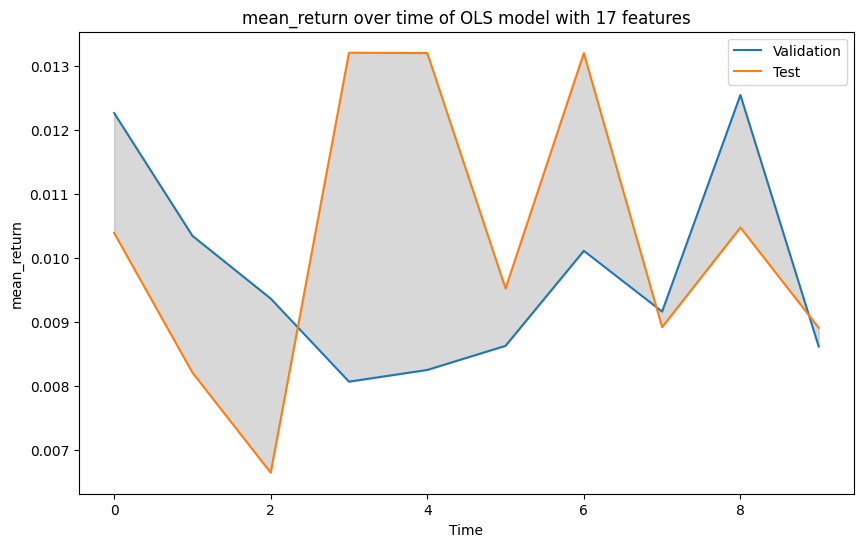

In [24]:
model5 = helper.Model('OLS')
model5.train(train_df, feature_col_names = ga_features)
model5.test(TEST_DF)
helper.validation_plot(data, model5, 10, "20211201", train_data_count=30, data_path=FILE_PATH, forward_dayCount = 15, features = ga_features)

### LASSO - Genetic Algo

In [25]:
df = train_df.drop(consts.RESPONSE_NAME, axis = consts.COL, inplace = False)
lasso_ga_feature_indices = helper.genetic_algorithm(train_df, TEST_DF, lasso_features)
lasso_ga_features = [df.columns[i] for i in range(len(lasso_ga_feature_indices)) if lasso_ga_feature_indices[i] == 1]
export_path = "Hoang_lasso_genetic_algo_features.txt"
helper.extract_features_to_file(lasso_ga_features, export_path)

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 89
response_corr: 0.8729104835964312
scale_factor: 0.9765281973314063
mean_return: 0.009243641561297415
Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.


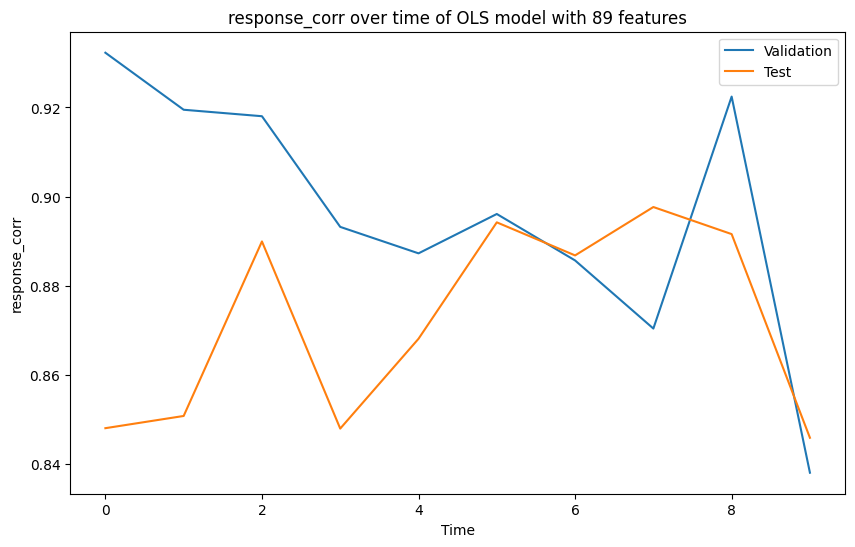

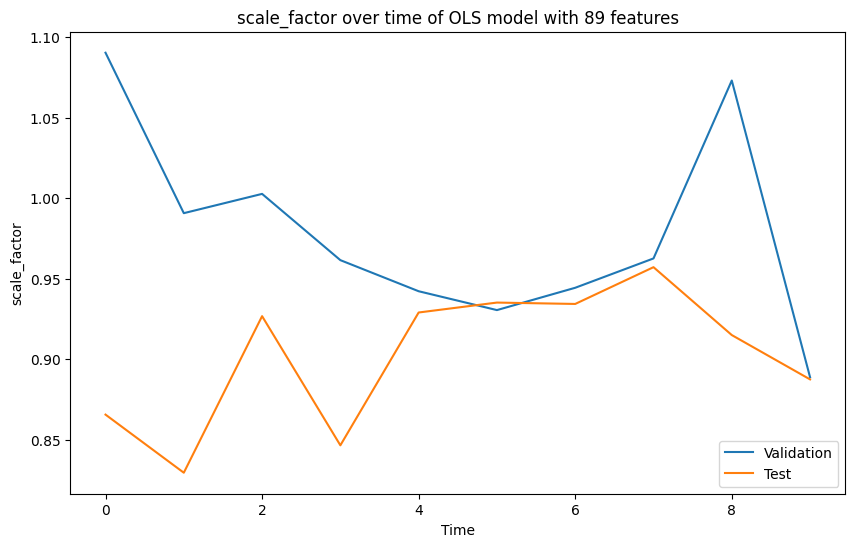

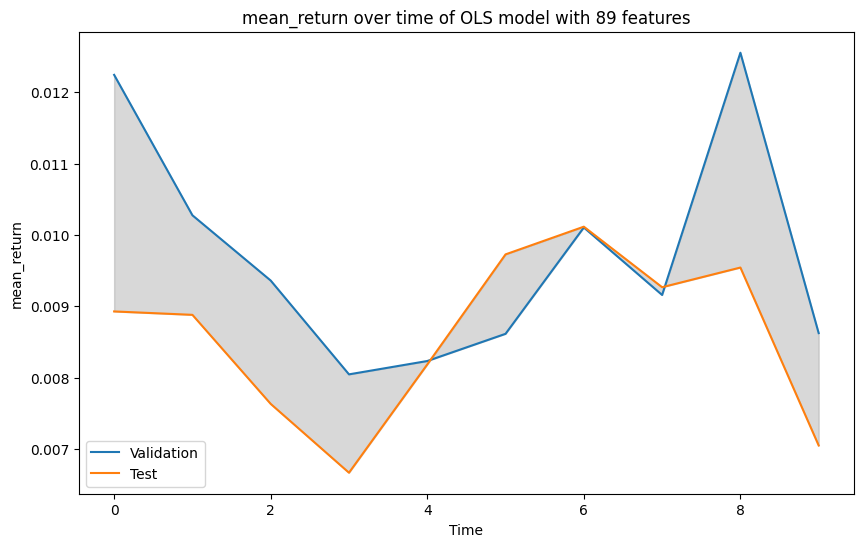

In [26]:
model6 = helper.Model('OLS')
model6.train(train_df, feature_col_names = lasso_ga_features)
model6.test(TEST_DF)
helper.validation_plot(data, model6, 10, "20211201", train_data_count=30, data_path=FILE_PATH, forward_dayCount = 15, features = lasso_ga_features)

This is very interesting as we saw our custom genetic algorithm shows a superior performance from out-of-sample data in Stepwise-Genetic and close performance in LASSO-Genetic

## Non-linear Feature Selection

### Customized functions just for feature selection

In [27]:
transform_func = lambda x: 1 if x > 0 else (-1 if x < 0 else 0)

In [28]:
def classification_tree_feature_selection(FEATURES: list[str], class_weight: dict[int]):
    class_data = helper.Data(train_data_path=FILE_PATH)
    class_data.update_and_get_train_df(TEST_DATE, backward_dayCount = 1)
    class_data.update_and_get_test_df(data_path=FILE_PATH, start_date=TEST_DATE)
    class_data.transform_col("classification", col_name = consts.RESPONSE_NAME, transform_func = transform_func)

    train_y = class_data.train_df[consts.RESPONSE_NAME]
    train_X = class_data.train_df.drop(consts.RESPONSE_NAME, inplace=False, axis = consts.COL)

    test_y = class_data.test_dfs[0][consts.RESPONSE_NAME]
    test_X = class_data.test_dfs[0].drop(consts.RESPONSE_NAME, inplace=False, axis = consts.COL)

    model1 = helper.Model("DecisionTreeClassifier", hyperparam_dict = {"random_state": 0, "class_weight": class_weight})
    model1.remove_metric()
    model1.add_metric('correctness', lambda pred_y, actual_y: sum(pred_y == actual_y) / len(actual_y))

    path = model1.inner.cost_complexity_pruning_path(train_X, train_y)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    alphas = np.arange(0, max(ccp_alphas), .01)

    train_df = class_data.train_df
    test_df = class_data.test_dfs[0]

    train_scores = []; test_scores = []
    for alpha in alphas:
        kwarg = {"random_state": 0, "class_weight": class_weight, "ccp_alpha": alpha}
        model = helper.Model("DecisionTreeClassifier", hyperparam_dict = kwarg)
        model.remove_metric()
        model.add_metric("accuracy", lambda x, y: np.sum([x[i] == y[i] for i in range(len(x))]) / len(x))
        model.train(train_df, feature_col_names=FEATURES, verbose = False)
        
        model.test(train_df, verbose = False); train_scores.append(model.metric_output["accuracy"])
        model.test(test_df, verbose = False); test_scores.append(model.metric_output["accuracy"])
        
    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
    ax.plot(alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
    ax.legend()
    plt.show()

In [29]:
def random_forest_feature_selection(FEATURES: list[str], start_date: int, end_date: int, 
                                    ALPHA: int, class_weight: dict[int]):
    train_dfs = []
    for i in range(start_date, end_date + 1):
        rf_data = helper.Data(train_data_path=FILE_PATH)
        rf_data.update_and_get_train_df(TEST_DATE, backward_dayCount = 1 + i)
        rf_data.update_and_get_test_df(data_path=FILE_PATH, start_date=TEST_DATE)
        
        try: rf_data.transform_col("classification", col_name = consts.RESPONSE_NAME, transform_func = transform_func)
        except: continue
        
        train_dfs.append(rf_data.train_df)

    def filter_features(features, scores):
        return [feature for feature, score in zip(features, scores) if score > 0]

    feature_important_scores = [0 for _ in range(len(FEATURES))]
    for train_df in train_dfs:
        kwarg = {"random_state": 0, "bootstrap": False, "class_weight": class_weight, "ccp_alpha": ALPHA}
        rf_model = helper.Model("RandomForestClassifier", hyperparam_dict=kwarg)
        rf_model.train(train_df, feature_col_names=FEATURES, verbose=False)

        for i in range(len(FEATURES)):
            feature_important_scores[i] += rf_model.inner.feature_importances_[i]

    filtered_features = filter_features(FEATURES, feature_important_scores)
    helper.classification_validation_plot(rf_data, transform_func, model2, 10, TEST_DATE, train_data_count= 30, 
                        data_path=FILE_PATH, forward_dayCount = 15, features = filtered_features)
    
    return filtered_features

### Random Forests - LASSO - GA

In [52]:
importlib.reload(helper); importlib.reload(consts)

<module 'consts' from '/Users/hoangchu/Documents/Clinic/code/consts.py'>

#### Find the tree regularization parameter from Classification Tree Pruning

Getting files from 2021-11-29 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
You're using: DecisionTreeClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
You're using: DecisionTreeClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'b

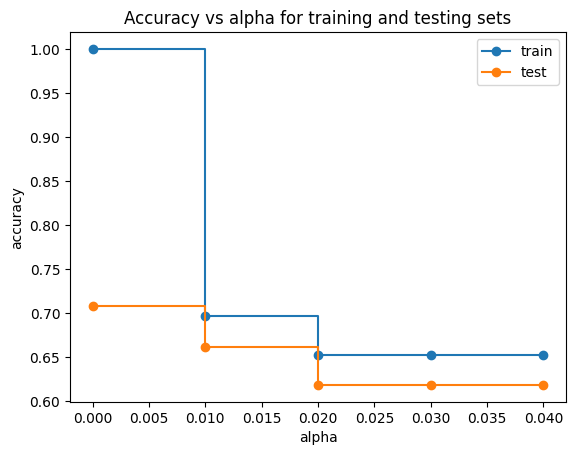

In [53]:
classification_tree_feature_selection(lasso_ga_features, class_weight = {-1:1,1:1.2})

In [54]:
ALPHA = 0.02

#### Feature Selection from Random Forests

In [55]:
rf_lasso_ga_features = random_forest_feature_selection(lasso_ga_features, 10, 20, ALPHA, class_weight = {-1:1,1:1.2})
export_path = "Hoang_RF_lasso_genetic_algo_features.txt"
helper.extract_features_to_file(rf_lasso_ga_features, export_path)

Getting files from 2021-11-19 00:00:00 to 2021-11-20 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-11-18 00:00:00 to 2021-11-19 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-11-17 00:00:00 to 2021-11-18 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-11-16 00:00:00 to 2021-11-17 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-11-15 00:00:00 to 2021-11-16 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-11-14 00:00:00 to 2021-11-15 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-11-13 00:00:00 to 2021-11-14 00:00:00, inclusive.
File w/ end date 2021-11-14 00:00:00 d

We don't need to care about performance that much as it's inflated by classification (what we want is Tree Regression in the 2nd stage).

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 40
response_corr: 0.8796448394606032
scale_factor: 0.9901153344936886
mean_return: 0.009425815832875205
Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.


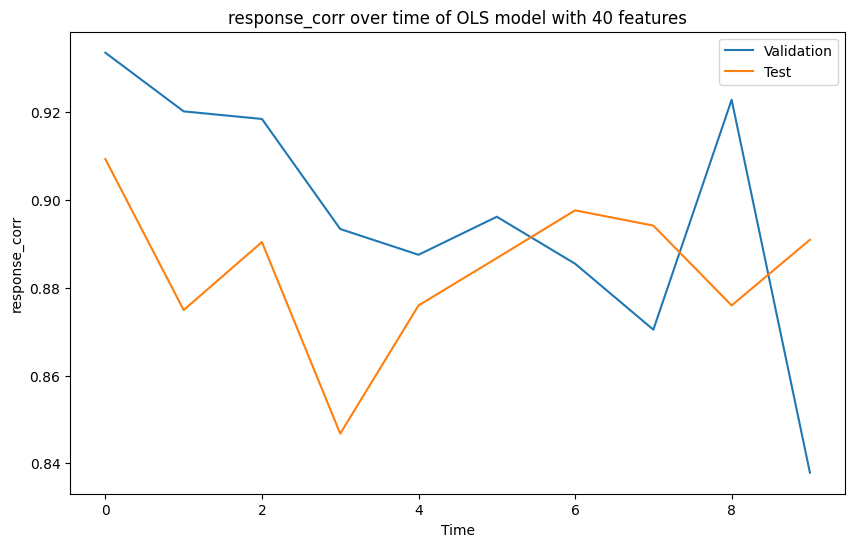

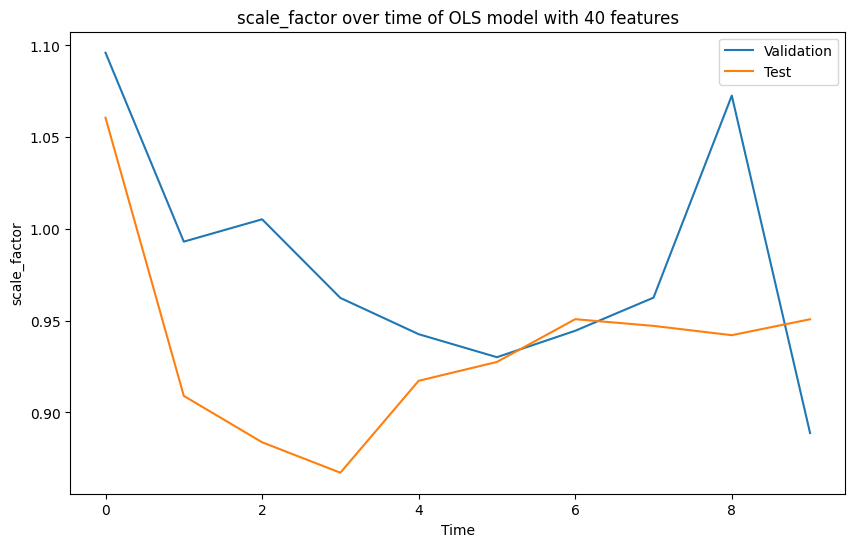

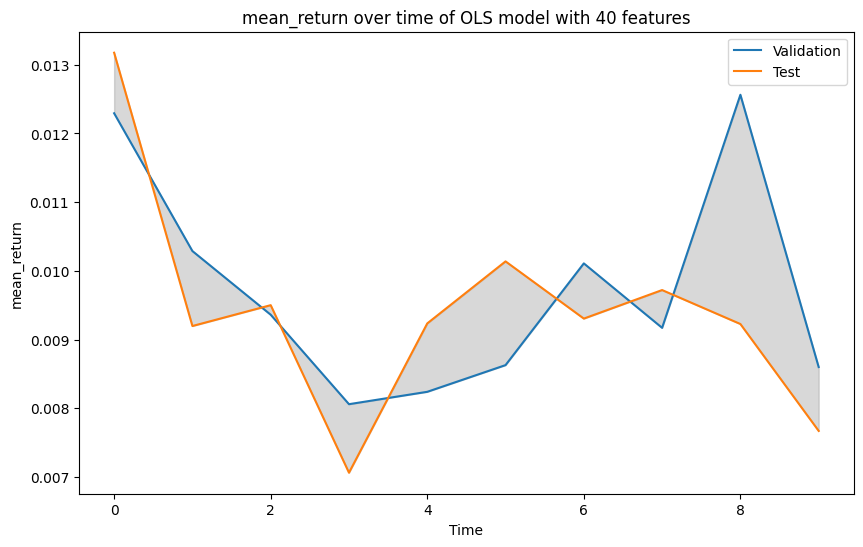

In [56]:
model7 = helper.Model('OLS')
model7.train(train_df, feature_col_names = rf_lasso_ga_features)
model7.test(TEST_DF)
helper.validation_plot(data, model7, 10, "20211201", train_data_count=30, data_path=FILE_PATH, forward_dayCount = 15, features = rf_lasso_ga_features)

### Random Forests - Stepwise - GA

In [57]:
importlib.reload(helper); importlib.reload(consts)

<module 'consts' from '/Users/hoangchu/Documents/Clinic/code/consts.py'>

#### Find the tree regularization parameter from Classification Tree Pruning

Getting files from 2021-11-29 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
You're using: DecisionTreeClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
You're using: DecisionTreeClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'b

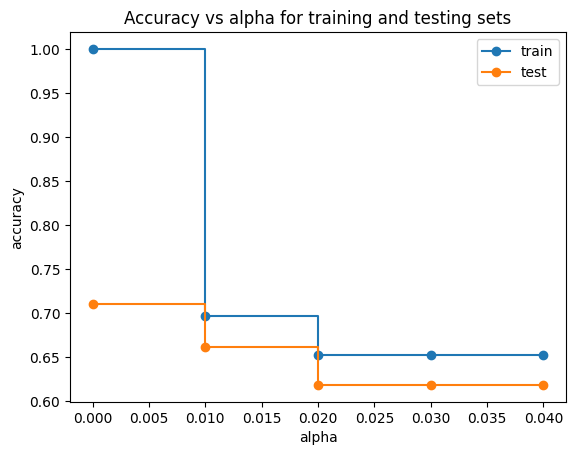

In [58]:
classification_tree_feature_selection(ga_features, class_weight = {-1:1,1:1.2})

#### Feature Selection from Random Forests

In [59]:
ALPHA = 0.02

In [60]:
rf_stepwise_ga_features = random_forest_feature_selection(ga_features, 10, 20, ALPHA, class_weight = {-1:1,1:1.2})
export_path = "Hoang_RF_stepwise_genetic_algo_features.txt"
helper.extract_features_to_file(rf_stepwise_ga_features, export_path)

Getting files from 2021-11-19 00:00:00 to 2021-11-20 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-11-18 00:00:00 to 2021-11-19 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-11-17 00:00:00 to 2021-11-18 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-11-16 00:00:00 to 2021-11-17 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-11-15 00:00:00 to 2021-11-16 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-11-14 00:00:00 to 2021-11-15 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Getting files from 2021-11-13 00:00:00 to 2021-11-14 00:00:00, inclusive.
File w/ end date 2021-11-14 00:00:00 d

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 17
response_corr: 0.8820767151827378
scale_factor: 0.9919467174034852
mean_return: 0.009366783397471138
Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.


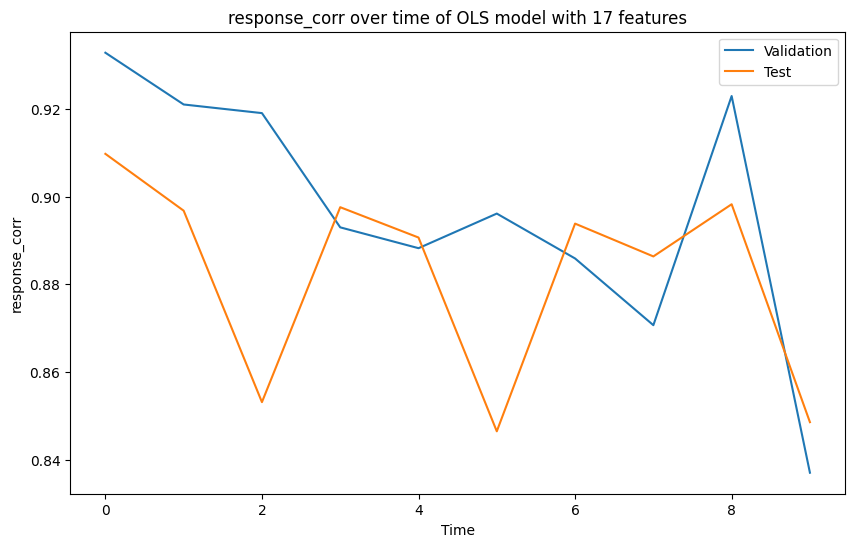

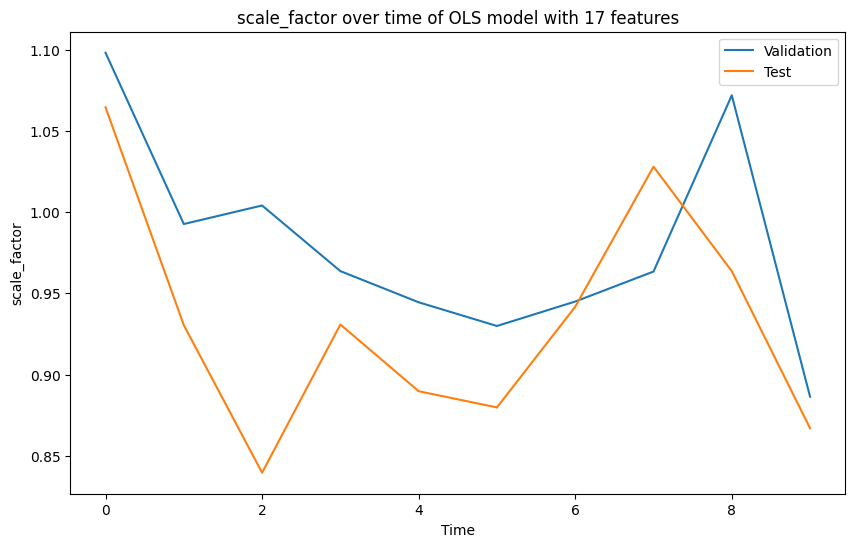

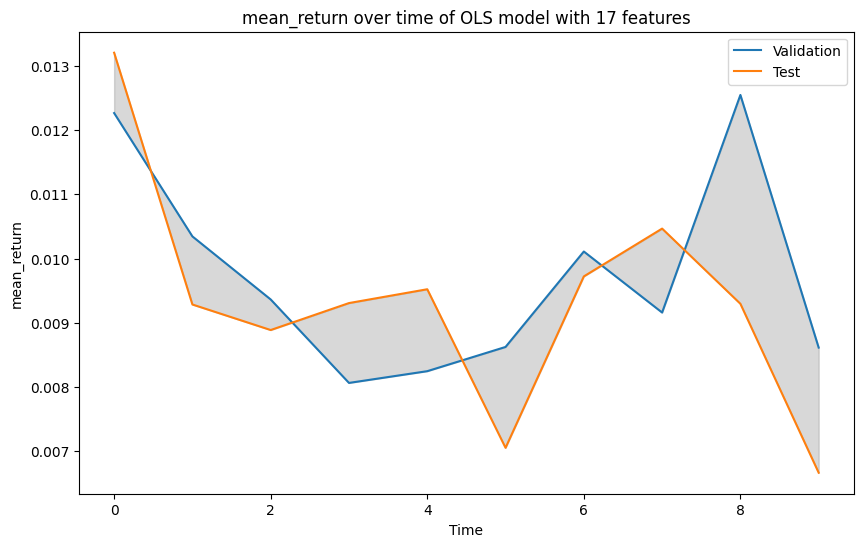

In [61]:
model8 = helper.Model('OLS')
model8.train(train_df, feature_col_names = rf_stepwise_ga_features)
model8.test(TEST_DF)
helper.validation_plot(data, model8, 10, "20211201", train_data_count=30, data_path=FILE_PATH, forward_dayCount = 15, features = rf_stepwise_ga_features)

Notice that for Tree - Stepwise - GA, the number of features don't change from Stepwise - GA while the Out-of-sample performance was following the same movement but underwhelming compared to Stepwise - GA. This means 17 features is the lower limit and we should not go below it for underfitting.

### CONCLUSION

As our customized genetic algorithm performs very well, we decided to pick the features generated from the combination of genetic + LASSO and genetic + Stepwise to our next step of going through different nonlinear models to see how well those features survive under nonlinear modeling and prediction.